

# Fourier Analysis in NT and Markets

In this warmup notebook, we compare the application of Fourier series analysis in Number Theory and market data.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
import scipy.stats as stats
import yfinance as yf
import datetime as dt

In [2]:
def von_Mangoldt(N):
    #Return an np.arrey Lambda[0,1,...,N], where Lambda is a simplified von mangoldt function, taking log value on primes. With the convention \Lambda(0)=0
    Lam=np.zeros(N, dtype=float)
    is_prime=np.ones(N+1, dtype=bool)

    for p in range(2, N):
        if not is_prime[p]:
            continue
        is_prime[p*p::p]=0
        Lam[p]=log(p)
    return Lam

By the Prime-Number Theorem, the sum of von Mangoldt up to N should be around N.

In [3]:
primo=9699690 #2*3*5*7*11*13*17*19

N=primo*1 #Chosing a multiple of primorial, to make the effect of small prime divisor of frequency denominator better visible.

Lambda=von_Mangoldt(N)
print("N:", N, "sum Lambda:", Lambda.sum())

N: 9699690 sum Lambda: 9696470.977783008


Calculate some basic stats, which are of course not very suitable for $\Lambda$, but useful for later comparison with SPY data.

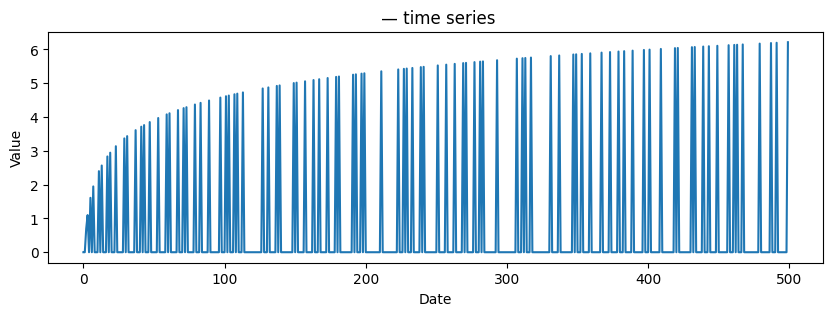

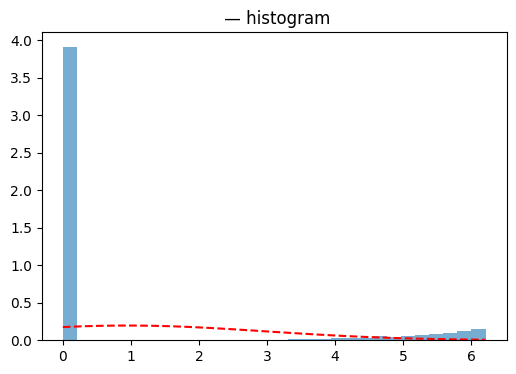

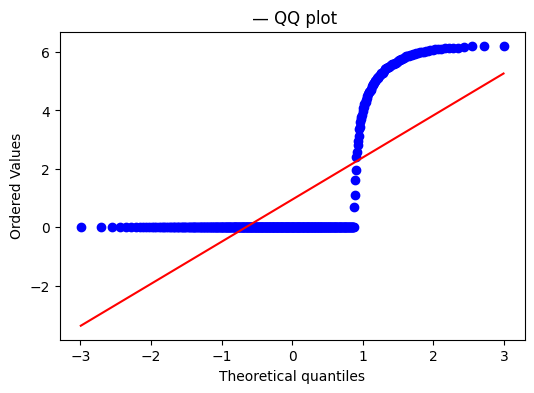

Mean is 0.9491088883093884 SD is 2.0274903431974143


In [4]:
def plot_column_distribution(x):

    # Time series (index on x-axis)
    plt.figure(figsize=(10,3))
    plt.plot(x)
    plt.title(f" — time series")
    plt.xlabel(f"Date")
    plt.ylabel("Value")
    plt.show()

    # Histogram
    plt.figure(figsize=(6,4))
    plt.hist(x, bins=30, density=True, alpha=0.6)
    mu, sigma = x.mean(), x.std(ddof=1)
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, stats.norm.pdf(xs, mu, sigma), "r--")
    plt.title(f" — histogram")
    plt.show()

    # QQ plot
    plt.figure(figsize=(6,4))
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f" — QQ plot")
    plt.show()

    print(f'Mean is {x.mean()}', f'SD is {x.std()}')

plot_column_distribution(Lambda[0:500])

We next calculate $\hat{\Lambda}(\alpha)=\sum_{n\leq N}\Lambda(n) e^{2\pi i \alpha n}$

In [5]:



def hat(Array):
    #Simple fft that return alpha value and fourier transform. No padding or hann window.
    N=len(Array)
    alphas=np.arange(N)/N
    X=np.fft.fft(Array)
    return alphas, X


alphas, X=hat(Lambda)

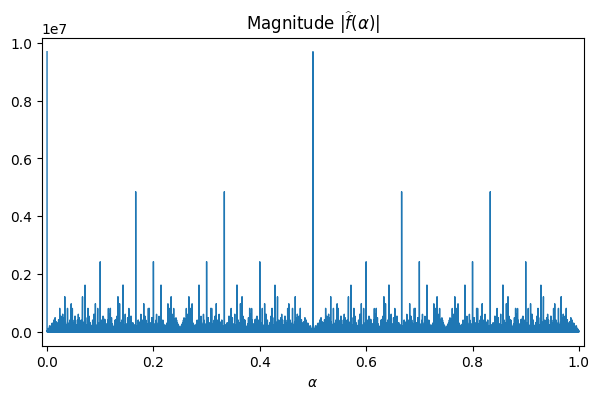

In [6]:
def plot_spectrum(alphas, X, zoom_max=0.1, logscale=False):
    mag=np.abs(X)
    plt.figure(figsize=(7,4))
    plt.plot(alphas, mag, lw=1)
    plt.xlim(-0.01, 1.01)
    plt.xlabel(r'$\alpha$')
    plt.title(r'Magnitude $|\widehat{f}(\alpha)|$')
    plt.show()

plot_spectrum(alphas, X, zoom_max=0.05)

We know that $|\hat{\Lambda}(\alpha)|$ should be of size $N/q$ if $\alpha$ is close to a rational number with denominator $q$. Let's extract this information numerically.

In [7]:

def large_spec(alphas, X, rel_size=0.01):
    mag=np.abs(X)
    thresh = rel_size * float(mag.max())
    large= mag > thresh
    print(f'The maximum magnitude is {mag.max()}, there are {large.sum()} out of {alphas.shape[0]} large signals')
    padded=np.r_[0, large.view(np.int8), 0] #reinterpret Bool as int values, and add 0 at beginning and end
    diff= np.diff(padded)  #Differentiate to discover runs
    starts= np.where(diff == 1)[0]
    ends= np.where(diff == -1)[0]
    sel_indices = []
    for s, e in zip(starts, ends):
        # choose index of max magnitude inside cluster
        cluster_idx = np.arange(s, e)
        local_idx = cluster_idx[np.argmax(mag[cluster_idx])]
        sel_indices.append(int(local_idx))
    sel_indices = np.array(sel_indices, dtype=int)
    order = np.argsort(-np.abs(X[sel_indices]))
    sel_indices = sel_indices[order]
    return alphas[sel_indices], X[sel_indices]


largalpha, largeX= large_spec(alphas, X)

The maximum magnitude is 9696470.977783008, there are 4538 out of 9699690 large signals


Testing some values:

In [8]:
print(np.abs(largeX))
print(largeX)
print(largalpha[10])
print(largeX[10])

[9696470.97778301 9696469.59148864 4848234.533011   ...   96966.52359202
   96965.16138097   96965.16138097]
[ 9696470.97778301+0.00000000e+00j -9696469.59148864-9.37916411e-11j
 -4848233.84097307-2.59042928e+03j ...   -96840.79135241+4.93637800e+03j
    96839.44400488+4.93605171e+03j    96839.44400488-4.93605171e+03j]
0.1
(2422179.2423295598-615.372089662932j)


We extract next a physical space approximant that capture behaviours at large Fourier frequencies, via
$$\Lambda_{\approx}=\Lambda*K(n),$$
where
$$K(n)=\sum_{\alpha \in \mathcal{S}} e(\alpha n)\frac{1_{|n|\leq L}}{2L+1}.$$

Since physical (time) space convolution requires $LN=cN^2$ ($c$ is scale below) steps, it is not feasible. Instead we use multiplication in frequency space and inverse Fourier, making use of the fact that FFT has time complexity $O(N\log N)$.

In [9]:
def L_approx(Lambda=Lambda, largalpha=largalpha, R=10, scale=0.1):
    #Inclusion of a scale means we carry information more than $1/N$ away from peaks. This is mathematically meaningful, since one can only show smallness of \hat{\Lambda} if we are sufficiently away from peaks.
    def _next_pow2(x):
        x = int(x)
        if x <= 1:
            return 1
        return 1 << ((x - 1).bit_length())

    N = Lambda.shape[0]
    Y = min(int(R), len(largalpha))

    ZN = int(np.floor(scale * N))
    if ZN < 0:
        ZN = 0

    alphas = np.array(largalpha[:Y], dtype=float)  # selected alphas
    Klen = 2 * ZN + 1                              # kernel length (t = -ZN..ZN)

    if Y == 0 or Klen == 0:
        return np.zeros(N, dtype=float)


    t = np.arange(-ZN, ZN + 1)                     # length Klen
    K_time = np.exp(2j * np.pi * np.outer(alphas, t)).sum(axis=0).astype(np.complex128) #This creates the function K in time (physical) domain, by first creating a matrix of pairs and summing then.


    L = N + Klen - 1
    M = _next_pow2(L)                                #We create a power of 2 that contains the maximal time space length required for the linear convolution. Standard FFT should use binary splitting, so this is the best choice trading run time and precision.

    # use complex FFTs because K_time is complex
    A = np.fft.fft(Lambda, n=M)
    B = np.fft.fft(K_time, n=M)
    conv_full = np.fft.ifft(A * B, n=M).real[:L]   #  convolution result

    # 'same' slice: align t=0 with index ZN -> take conv_full[ZN:ZN+N]
    start = ZN
    end = ZN + N
    conv_same = conv_full[start:end]

    # counts (averaging divisor): convolution of ones(N) with ones(Klen) via FFT. Thus normalising by unit interval convolution
    ones_N = np.ones(N, dtype=float)
    ones_K = np.ones(Klen, dtype=float)
    C = np.fft.ifft(np.fft.fft(ones_N, n=M) * np.fft.fft(ones_K, n=M), n=M).real[:L]
    counts = C[start:end]
    counts[counts == 0] = 1.0

    Lapprox = conv_same / counts
    return Lapprox

Lapprox = L_approx(Lambda, largalpha, R=20)


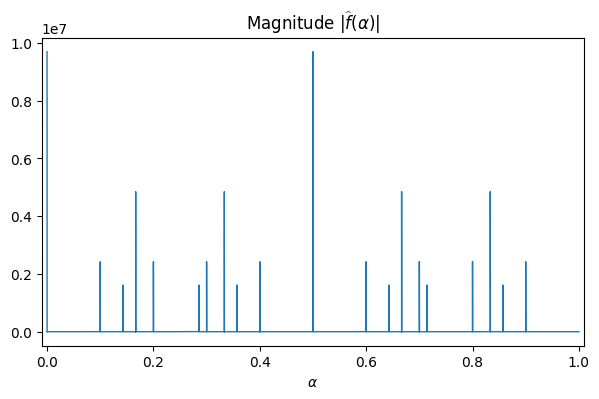

In [10]:
alphas1, X1 =hat(Lapprox)
plot_spectrum(alphas1, X1, zoom_max=0.05) #We should see the peaks from before.

Having confirmed that the spectral lines match the peaks, we gather some statistics.

In [13]:
def fit_stats(F, Fapprox):
    F = np.asarray(F, float)
    Fapprox = np.asarray(Fapprox, float)
    Fres=F-Fapprox

    L2=np.linalg.norm(Fres)
    rel_L2=L2/np.linalg.norm(F)

    Fc=F-F.mean()
    R2=1.0-(L2**2)/(np.linalg.norm(Fc)**2)

    resabs=np.abs(Fres)

    out = {
        "rel_L2": rel_L2,
        "R2_explained_var": R2,
        "RMSE": np.sqrt(np.mean(Fres*Fres)),
        "MAE": np.mean(resabs),
        "MedAE": np.median(resabs),
        "Q95_AE": np.quantile(resabs, 0.95),
        "Linf": np.max(resabs),
    }
    df = pd.DataFrame(out, index=["value"]).T
    return df

print(fit_stats(Lambda, Lapprox))



                      value
rel_L2             0.870080
R2_explained_var   0.189244
RMSE               3.379111
MAE                1.770452
MedAE              0.332872
Q95_AE            10.873033
Linf              12.944322


The most interesting stat is here the $19$% explained variance with only few frequencies.
## SPY Data
Let's see what happens if we apply the same methodology to SPY data next.

In [15]:
#Importing the YF SPY minute data in the last week
end = dt.datetime.now()
start = end - dt.timedelta(days=8)
data = yf.download(
    tickers="SPY",
    start=start,
    end=end,
    interval="1m",
    progress=False,
    auto_adjust=True
)

In [16]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Datetime,,,,,
2025-12-22 17:15:00+00:00,684.844971,684.926025,684.799988,684.809998,0
2025-12-22 17:16:00+00:00,684.929993,684.965027,684.835022,684.844971,102161
2025-12-22 17:17:00+00:00,684.924988,684.960022,684.890015,684.919983,79629
2025-12-22 17:18:00+00:00,684.849976,684.950012,684.849976,684.924988,85621
2025-12-22 17:19:00+00:00,684.840027,684.869995,684.799988,684.859985,67812


In [50]:

closeseq=data['Close'].to_numpy().ravel()
#cloenorm=closeseq-closeseq.mean()
closediff=np.diff(np.log(closeseq)) #Differences of logarithmi returns
closediff=closediff-closediff.mean() #Possible mean subtraction.
volseq=data['Volume'].to_numpy().ravel()
volseq=volseq-volseq.mean() #Necessary, because the 0 peak is else overwhelming.

print(closediff)
print(volseq)


[ 1.21386874e-04 -1.00603574e-05 -1.12278048e-04 ...  1.18038267e-05
  1.28072891e-04  1.71802854e-04]
[-130356.00567465  -28195.00567465  -50727.00567465 ...  497001.99432535
  983400.99432535 1067938.99432535]


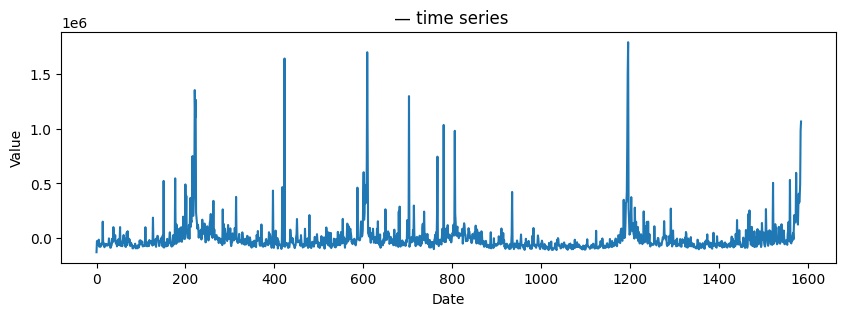

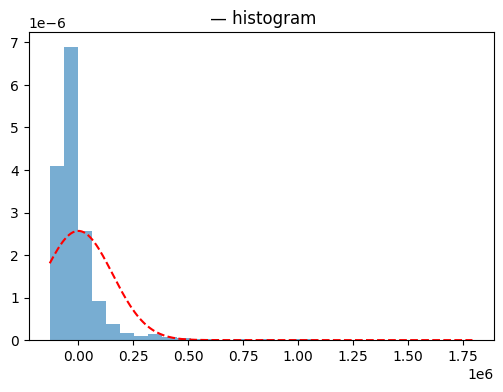

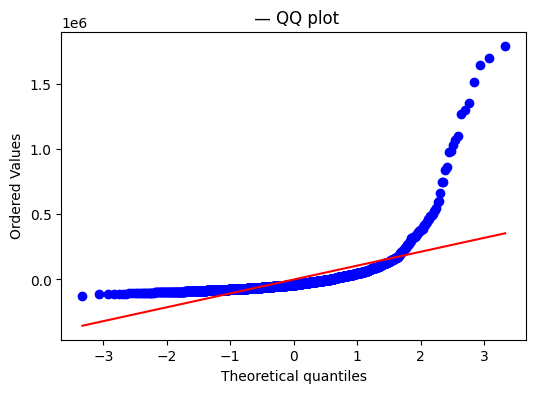

Mean is -4.697717904743902e-12 SD is 155282.7960987558


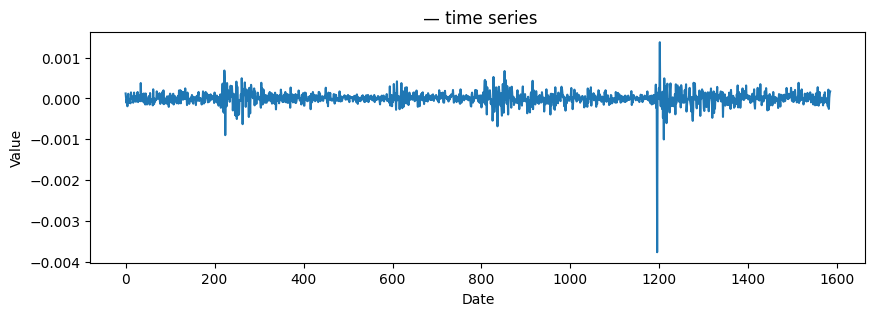

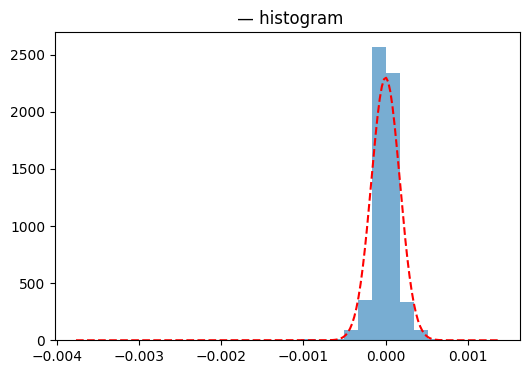

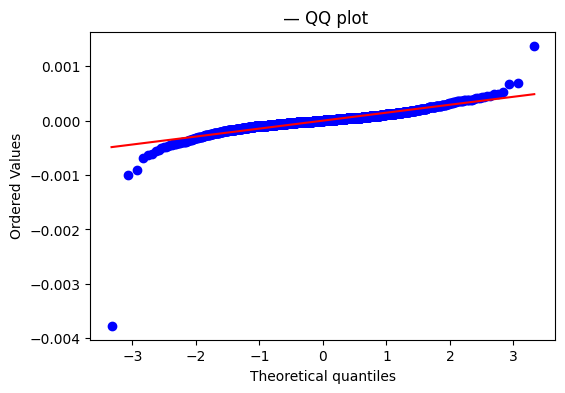

Mean is 4.925082423908916e-21 SD is 0.00017344882495211032


In [51]:
plot_column_distribution(volseq)
plot_column_distribution(closediff)

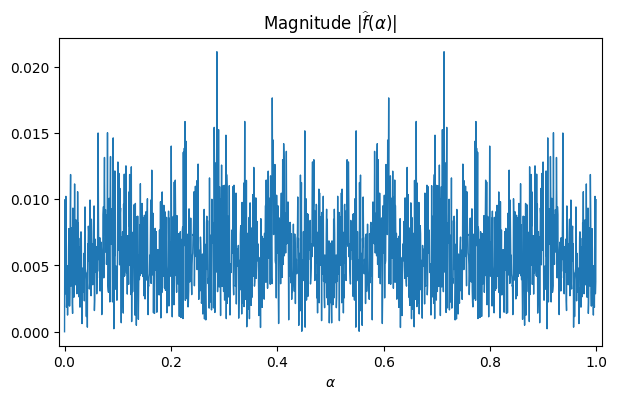

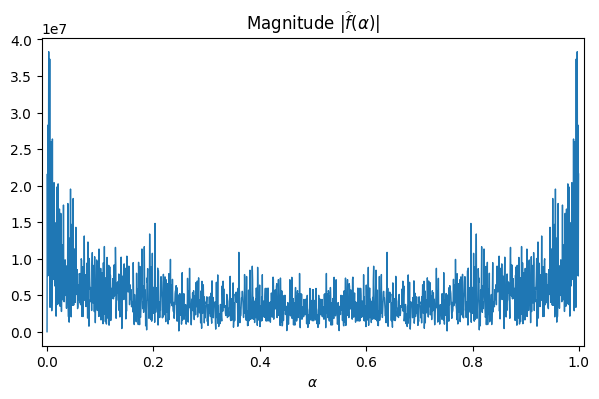

In [52]:
SPYalphas, SPYX=hat(closediff)
Volalphas, VolX=hat(volseq)

plot_spectrum(SPYalphas, SPYX, zoom_max=0.05)
plot_spectrum(Volalphas, VolX, zoom_max=0.05)

Next define set of large spectrum. Note that the pronounced noise, in particular in the difference sequence, requires us to fine tune the rel_size parameter so that not all peak areas are overlapping. For what we do below, we should choose it such that there are slightly over $30$ large signal frequencies.

In [48]:
largSPYalpha, largeSPYX= large_spec(SPYalphas, SPYX, rel_size=0.65)
largVolalpha, largeVolX= large_spec(Volalphas, VolX, rel_size=0.35)


print(np.abs(largeSPYX))
print(largSPYalpha)
#print(largSPYalpha[10])
#print(largeSPYX[10])


The maximum magnitude is 14.550932060929233, there are 34 out of 1585 large signals
The maximum magnitude is 38324831.94522387, there are 42 out of 1586 large signals
[14.55093206 14.55093206 12.13484305 12.13484305 10.92799915 10.92799915
 10.90142152 10.90142152 10.60410105 10.60410105 10.49797364 10.49797364
 10.42772127 10.42772127 10.34216064 10.34216064 10.32997094 10.32997094
 10.19987379 10.19987379 10.07786726 10.07786726  9.94061159  9.94061159
  9.87963627  9.87963627  9.76102732  9.76102732  9.65338101  9.65338101
  9.53000963  9.53000963]
[0.28643533 0.71356467 0.39053628 0.60946372 0.33880126 0.66119874
 0.22649842 0.77350158 0.28138801 0.71861199 0.71041009 0.28958991
 0.45173502 0.54826498 0.0807571  0.9192429  0.06309148 0.93690852
 0.30347003 0.69652997 0.09148265 0.90851735 0.60757098 0.39242902
 0.22839117 0.77160883 0.58801262 0.41198738 0.20063091 0.79936909
 0.22523659 0.77476341]


In [53]:
testR=[1,5,10,20,30]

for r in testR:
    SPYapprox = L_approx(closediff, largSPYalpha, R=r)
    print(f'For R={r}')
    print(fit_stats(closediff, SPYapprox))

For R=1
                     value
rel_L2            0.992432
R2_explained_var  0.015079
RMSE              0.000172
MAE               0.000100
MedAE             0.000066
Q95_AE            0.000299
Linf              0.003747
For R=5
                     value
rel_L2            0.977929
R2_explained_var  0.043656
RMSE              0.000170
MAE               0.000101
MedAE             0.000068
Q95_AE            0.000294
Linf              0.003657
For R=10
                     value
rel_L2            0.957454
R2_explained_var  0.083282
RMSE              0.000166
MAE               0.000100
MedAE             0.000069
Q95_AE            0.000289
Linf              0.003557
For R=20
                     value
rel_L2            0.926492
R2_explained_var  0.141612
RMSE              0.000161
MAE               0.000098
MedAE             0.000069
Q95_AE            0.000273
Linf              0.003404
For R=30
                     value
rel_L2            0.914030
R2_explained_var  0.164550
RMSE        

In [40]:
for r in testR:
    Volapprox = L_approx(volseq, largVolalpha, R=r)
    print(f'For R={r}')
    print(fit_stats(volseq, Volapprox))

For R=1
                         value
rel_L2            9.534022e-01
R2_explained_var  9.102428e-02
RMSE              1.480470e+05
MAE               6.939274e+04
MedAE             4.790206e+04
Q95_AE            1.576237e+05
Linf              1.754647e+06
For R=5
                         value
rel_L2            9.274302e-01
R2_explained_var  1.398732e-01
RMSE              1.440140e+05
MAE               7.759171e+04
MedAE             5.281132e+04
Q95_AE            1.908108e+05
Linf              1.634757e+06
For R=10
                         value
rel_L2            9.143979e-01
R2_explained_var  1.638765e-01
RMSE              1.419903e+05
MAE               7.823661e+04
MedAE             4.998761e+04
Q95_AE            2.242546e+05
Linf              1.638009e+06
For R=20
                         value
rel_L2            8.639303e-01
R2_explained_var  2.536244e-01
RMSE              1.341535e+05
MAE               7.688714e+04
MedAE             5.041989e+04
Q95_AE            2.279235e+05
Linf 

Let's compare those values against two types of random surrogate models:
1. phase-randomised
2. i.i.d bootstrap